<a href="https://colab.research.google.com/github/wizard339/NLP_MISIS/blob/main/week2/seminar_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 2 (Word representation and CNN for text classification)

## Purpose of the lesson

In this lesson, we will touch on two topics: 
- data research through training your language model and studying the vector representation of words from data
- solving practical problem of classifying the sentiment of the text.

Practical skills, that you will learn:
- training model, that handle distributional semantics over your training dataset;
- dimension reduction to more effectively handle vectors and futher use simplier and more light weighted machine learning models;
- representation of vectors on 2 dimensional graphics to find some structure in data, relative positions of vectors and similar meanings of words;
- downloading open-source datasets for sentiment analysis;
- downloading pretrained on large corpus weights;
- initialize pretrained weights to your model and use them to get better quality of model;
- writing custom class to process data for your model;
- learn how to use CNN for text classification;
- write simple training/validation loop to train your model;
- some kind of transfer learning to solve text classification task for faster, using less data and more effectively.

## PART 1

In Part 1 we use texts, but you can also use other data to train vector represention of your tokens.<br> For example: each nodes in graph can be represented as random walk over neighbour nodes. After learning vector representation of your nodes you can cluster your data. It is computational more effective, because all graph clustering algorigtms have O(n**2) complexity and harder.<br>
Or you can represent your customers as chain of their transactions and then learn their representation.

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from typing import Union, List, Tuple, Dict, Set

### Vector normalization

When you work with classical ML problems you need to preprocess you features to equal scale. It helps models to faster converge and get more accurate solution.<br>
It`s all applicable for texts and their vector representation.

Lets get some simple vectors. They are similar, but have pretty different lenghts.

In [2]:
vectors = np.array([[ 7.,  8.,  5.,  5.],
                    [ 9.,  8., 10.,  8.],
                    [10.,  8.,  8.,  6.]])
vectors

array([[ 7.,  8.,  5.,  5.],
       [ 9.,  8., 10.,  8.],
       [10.,  8.,  8.,  6.]])

In [3]:
import torch.nn.functional as F

#### Task 1
Write function that get two vectors as input, normalize them to get length equal 1 and return them as torch.tensor for futher work in our Neural Networks.

We will use whis function when we will preprocess all vectors, that we get for our model. Especially if we get vectors from outside.

##### help

In [4]:
# 1. use torch.nn.functional module to normalize (there are normalize function)
# 2. don`t forget to cast types

##### continue work

In [5]:
# YOUR CODE HERE
def normalize_vectors(vectors: Union[List[Union[int, float]],
                                     np.array,
                                     torch.tensor]) -> torch.tensor:
  return F.normalize(torch.tensor(vectors)).type(torch.float64)

In [6]:
normed_vectors = normalize_vectors(vectors)

assert torch.norm(normed_vectors, dim=1).sum().item() == 3
assert normed_vectors.dtype == torch.float64

### Calculate vector similarity

To measure how similar are vectors we use cosine similariry. It`s formula is represented below.<br>
When we need to get deeper and faster insight into data, without clustering we can just calculate cosine similarity between vectors and get first understanding how common is concrete vector to other vectors.

#### Task 2
Write on pure numpy function that measure vector distance between two vectors. Each input vector is a numpy array. Return a single float number that measure similarity between vectors.
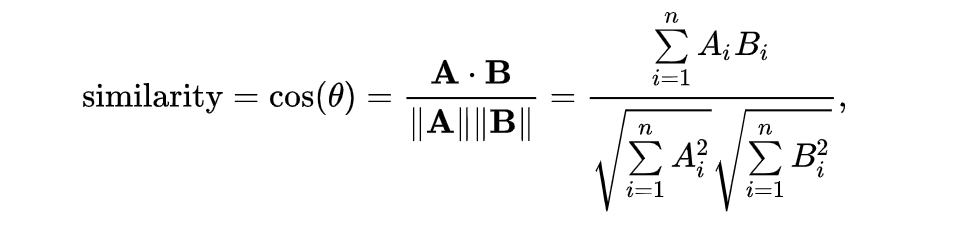

##### help

In [7]:
# 1. In numerator we get scalar multiplication of two vectors. It sums pairwise multiplication of each component in vectors
# 2. In denominator we get multiplication of length of each vector. We calculate it as L2-norm.

# You can use numpy functions below to calculate similarity

In [8]:
from numpy import dot
from numpy.linalg import norm

##### continue work

In [9]:
# YOUR CODE HERE
def cos_similarity(a: np.array, b: np.array) -> float:
  return dot(a, b) / (norm(a) * norm(b))

In [10]:
cos_sim_1 = cos_similarity(normed_vectors[0], normed_vectors[1])
cos_sim_2 = cos_similarity(normed_vectors[1], normed_vectors[2])

assert cos_sim_1 < cos_sim_2
assert cos_sim_1 > 0.96
assert cos_sim_2 > 0.98

### Training vector representation from our data

If we have anough data or you are not familier with domain of your data you can train language model from just your data. After traing you can explore your vectors with some clusterning technics or just visualize vectors in 2d or 3d dimensions.

On lecture we discussed word2vec model. More complex and functional version of word2vec is Fasttext, that handle main problem of word2vec - Out-Of-Vocabulary words. Implementation of this model and some basic functionality with it you can find in python library fasttext. It is disigned by Facebook.

In [11]:
!pip install fasttext

     |████████████████████████████████| 68 kB 4.6 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3123402 sha256=ea69396e161fcd1c159ec367c31205d6748b1c853572dc2947435bbdef8fa7b4
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


Download data of russian comments form Odnoklassniki social network

In [12]:
!wget https://raw.githubusercontent.com/snv-ds/NLP_course/master/week2/train

--2021-10-09 08:34:37--  https://raw.githubusercontent.com/snv-ds/NLP_course/master/week2/train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24525472 (23M) [text/plain]
Saving to: ‘train’

train               100%[===================>]  23.39M  --.-KB/s    in 0.1s    

2021-10-09 08:34:39 (165 MB/s) - ‘train’ saved [24525472/24525472]



Importing fasttext library to use FastText model implemented there

In [13]:
import fasttext

Our data is multilabel classification task. Classes represented in data you can see below.

In [14]:
parse_labels = ['__label__NORMAL','__label__INSULT','__label__THREAT','__label__OBSCENITY']

In [15]:
!head -n 20 train

41127	__label__THREAT	дворника надо тоже уничтожить!
6812	__label__NORMAL	моя старшая неделю шипела, не принимала подкидыша, которого я принесла. китя такой славный, потерпите немного, мои теперь душа в душу живут, ваша примет попозже. а котенок необыкновенно красивый.
6256	__label__NORMAL	полностью с вами согласна!
189636	__label__NORMAL	хоть ногу вверх, ничего не изменится
99053	__label__NORMAL	а что значит - левого ребенка?
98418	__label__NORMAL	вечер добрый! а, что он у вас уже постарел?!
3619	__label__NORMAL	какая порода .?
176463	__label__INSULT	спасатель? просто петух чванливый, взял наших пацанов в заложники и торгуется. позор! как бы сам в щи не попал.
13520	__label__NORMAL	с замечательным юбилеем!!! голос- чудо, заслушаешься 😍и про чтение все правильно- ничто не сравнится с бумажной книгой!
133613	__label__NORMAL	еще бы .такой красавец.
77333	__label__NORMAL	есть вот такое фото культурно-массового мероприятия.
201554	__label__NORMAL	можно бесконечно искать недостатки! мудрак 

Here we will load data, prepocess each row to get features as OHE vectors and translate target features on russian.

In [16]:
train = pd.read_csv('/content/train', sep='\t', names=['id','target','temp1','temp2','comment'], index_col=0)

mask = train['comment'].isin(parse_labels)  # to cope only with correct rows in data
train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask]['comment']
train.loc[mask,'comment'] = np.nan

for t in ['temp1','temp2']: # if comment have several labels of classes
    mask = train[t].isin(parse_labels)
    train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask][t]
    train.loc[mask,t] = np.nan
    train.loc[~train[t].isna(),'comment'] = train[~train[t].isna()][t]

train[['оскорбление','другое','непростойность','угроза']] = train['target'].str.get_dummies(sep=',')

train = train[['другое','оскорбление','непростойность','угроза', 'comment']]
train.sample(7)

,другое,оскорбление,непростойность,угроза,comment
id,,,,,
60468,1,0,0,0,"а по закону россии, производители белорусских ..."
62208,1,0,0,0,"вы счастливый человек,и я ничем никогда ее не ..."
88075,1,0,0,0,не. советую ерунда
49481,1,0,0,0,живая картина... респект автору!
146731,1,0,0,0,засранка....почему не было контакта с родителя...
160607,1,0,0,0,нормальная переднепреводная
231335,1,0,0,0,"нпзвание чопа,будьте добры?"


#### Task 3
Initialize variables for texts and targets from train data. Next time we will process this variables in our language model.<br> This action is very frequent and we want to automate it.

Each variable will contain np.array values from our train pandas.DataFrame. <br>Numpy is very fast to process, thats why we try to use it more often.

In [17]:
# YOUR CODE HERE
texts = train['comment'].values
targets = train[['другое', 'оскорбление', 'непростойность', 'угроза']].values
# or:
# texts = np.array(train['comment'])
# targets = np.array(train[['другое', 'оскорбление', 'непростойность', 'угроза']])

In [18]:
assert texts.shape[0] == 148775
assert targets.shape[1] == 4
assert texts.shape[0] == targets.shape[0]

#### Task 4


To load data in FastText model we need to correctly represent it. FastText works only with corpus, where every document is splited by `\n` symbol. When we train model on our data we can then represent each word in it as vector and continue exploring data from mathematical point of view.

Create file `messages_unsupervised.txt`, that will contain all messages separeted by the `\n` symbol. This file we will futher use to train FastText model

In [22]:
# YOUR CODE HERE
with open('messages_unsupervised.txt', 'w', encoding='utf8') as f:
  f.write('\n'.join(texts))

In [23]:
import os

assert 'messages_unsupervised.txt' in os.listdir('./')

Start training vector representation of words in our data is very simple. We can just pass generated file in method `train_unsupervised` of fasttext library and set some parameters. Fasttext model use ngams of symbols in words to handle OOV problem. By setting params `minn` and `maxn` we set number of ngrams we will generate. Param `dim` set output dimension of our data.

In [24]:
%%time
ft_vectors = fasttext.train_unsupervised('messages_unsupervised.txt', minn=3,maxn=5, dim=50)

CPU times: user 1min 25s, sys: 358 ms, total: 1min 25s
Wall time: 1min 25s


Now we can see most similar vectors in our dataset to given word

In [25]:
ft_vectors.get_nearest_neighbors('дебил')

[(0.9432968497276306, 'дебил.'),
 (0.9353195428848267, 'дебил,'),
 (0.9222123622894287, 'дебил?'),
 (0.9192084670066833, 'дебил!'),
 (0.8878727555274963, 'дебилу'),
 (0.8567968010902405, 'далбоёб'),
 (0.8566405773162842, 'мудак'),
 (0.8459110260009766, 'мудак.'),
 (0.8396469354629517, 'далбаеб'),
 (0.8340746164321899, 'козёл,')]

Let`s visualize our vectors

For visualization we first need to reduce dimension of our data to 2d or 3d, because only this we can illustrate.<br>
One of appropriate methods, that we can use to reduce dimensions is TSNE. It is implemented in MulticoreTSNE python library. <br>
Another methods that can reduce dimension is:
- UMAP (implemeted in umap library)
- SVD (implemented in sklearn)
- PCA (implemented in sklearn)

In [26]:
!pip install MulticoreTSNE > /dev/null

In [27]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split


from sklearn.decomposition import TruncatedSVD
from MulticoreTSNE import MulticoreTSNE as TSNE

We have so much words in our dataset. Lets take only 3 000 most frequent one, to visualize only them.

In [28]:
print(len(ft_vectors.words))
top3k = ft_vectors.words[:3000]
top3k[:10]

30552


['</s>', 'и', 'не', 'в', 'на', 'а', 'с', 'что', 'это', 'я']

#### Task 5

initialize `top3k_vectors` variable with all vectors, that are in top 3000 for frequency.<br> 
Result variable will be list of vectors. Each vector present concrete word representation.

In [29]:
# YOUR CODE HERE
top3k_vectors = [ft_vectors.get_word_vector(i) for i in top3k]

In [30]:
%%time
tsne_emb = TSNE(n_components=2,
                n_iter=2000,
                n_jobs=-1,
                random_state=42).fit_transform(np.array(top3k_vectors))

CPU times: user 1min 9s, sys: 247 ms, total: 1min 9s
Wall time: 39.1 s


In [32]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save", title="TSNE representation of FastText vectors (top 3k words)")

source = ColumnDataSource(data=dict(x1=tsne_emb[:,0], x2=tsne_emb[:,1], names=top3k))

p.scatter(x="x1", y="x2", source=source, size=5)

words = LabelSet(x="x1", y="x2", text="names", source=source,
                y_offset=6, text_font_size="6pt", 
                 text_color="#555555", text_align="center")

p.add_layout(words)

show(p)

Now try to preprocess texts and train fasttext one more time!<br>
write function to preprocess texts. You can do whatever you want:
 - delete stop words
 - delete punctuation
 - lematize words
 - stemming
 - lower texts

 After that you can explore texts and their representation

# Part 2

In this task we will solve task of classification sentiment of text. For this purpose install python library datasets which contains IMDB dataset. This is dataset for binary classification. <br>
Our main goals are:
- solve real task;
- try to write custom classes for processing data;
- use pretrained vector representaition (aka transfer learning);
- try new arhitecture for classification task.

In [33]:
!pip install datasets > /dev/null

In [34]:
import datasets

Loading IMDB dataset

In [35]:
text_dataset = datasets.load_dataset("imdb")

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

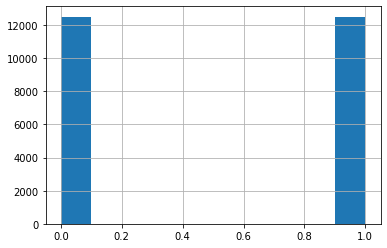

In [36]:
pd.DataFrame(text_dataset['train'], columns=['label', 'text'])['label'].hist();

In [37]:
df = pd.DataFrame(text_dataset['train'], columns=['label', 'text'])

#### Task 6


This dataset is rather large, we don`t need so much data. Let's trim our dataset and take only part of it.

Initialize new df as half of randomly chosen rows of df.<br>
You can use different built-in pandas methods, such as sample, loc, iloc.

In [39]:
# YOUR CODE HERE
df = df.sample(len(df) // 2)

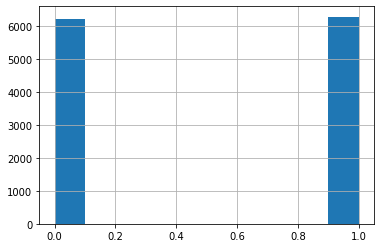

In [40]:
df['label'].hist();

Before we start working with text, we need to learn how to initialize some layer of neural network with pretrained or predefined vectors.<br> We will use this mechanism if work with pretrained words representaion or pretrained layers of other network.

In [41]:
# initialize some vectors
some_vectors = torch.rand((10,50), dtype=torch.float32)

In [42]:
# some random linear layer of neural network
custom_layer = nn.Embedding(10, 50)

In [43]:
# initialize weights of defined layer with early given vectors
custom_layer.weight = nn.Parameter(some_vectors.clone().detach().requires_grad_(True))

#### Downloading pretrained vectors

In NLP we have some libraries, that contains pretrained word representaions trained on large corpuses of texts. Some times they contains word representations for several languages (also russian).<br>
One library, that we will use `Gensim`.

In [44]:
import gensim.downloader

We can see what models represented in whis library

In [45]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

Gensim contains vector representaion not only for word2vec, but for `Glove` and `Fasttext`. All of them give us realization of distributional semantics converted in different, but rather similar approaches.<br>
We will use `glove` vectors just for their light weights and appropriate representation. You can try some other models by yourself.

In [46]:
glove_vectors = gensim.downloader.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [47]:
glove_vectors.vectors.shape

(1193514, 100)

In [ ]:
list(glove_vectors.vocab.keys())[250:300]

#### Task 7

Initialize loaded weights from gensim to some embedding layer.

In [50]:
# YOUR CODE HERE
embedding_matrix = glove_vectors.vectors
embedding = nn.Embedding(*glove_vectors.vectors.shape)
embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))

In [51]:
assert embedding_matrix.shape == (1193514, 100)
assert embedding_matrix[23].sum() < -4.45
assert cos_similarity(embedding_matrix[42], embedding_matrix[23]) < 0.57

After get loaded pretrained weights we can get back to explore data. We will use simple nltk WordPuckt tokenizer to split  punctuation and words from each other. Also you can try here TwitterTokenizer or some other methods.

In [52]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

Look at the lengths of each sample of data and collect in list `l`

In [53]:
l = float('-inf')
l = list()
for text in tqdm(df['text']):
    l.append(len(tokenizer.tokenize(text.lower())))

  0%|          | 0/12500 [00:00<?, ?it/s]

count    12500.000000
mean       283.791440
std        211.770728
min         11.000000
25%        152.000000
50%        211.000000
75%        346.000000
max       2054.000000
dtype: float64


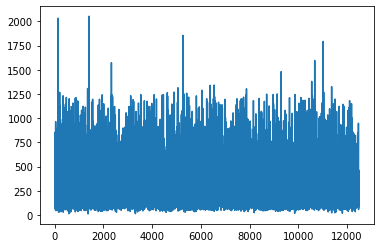

In [56]:
print(pd.Series(l).describe())
pd.Series(l).plot()

If you see outliers of length you can preprocess your data and delete or split such long examples.

it can be seen that 90% of the texts do not exceed 1500 tokens. Let's take the quantile 0.95 with a margin and initialize the variable max_len with this value.

#### Task 8

Just for simplicity we will delete samples, that have legth over some border value.<br>
Take the quantile 0.95 of `l` with a margin and initialize the variable max_len with this value.

In [58]:
# YOUR CODE HERE
max_len = int(pd.Series(l).quantile(0.95))
max_len

730

Create vocab of each token in our dataset.<br>
Some approaches to fix their order:
- we can count frequencies of each token, enumerate their order and fix it;
- use countvectorizer form sklearn;
- lexicographically sort all tokens in vocab and fix order.<br>

You can come up with your own method - it`s all up to you.

In [59]:
from collections import Counter

We will count all tokens and fix their ranks. <br>
All unknown tokens, that are not present in vocab we will translate into special `<UNK>` token, thats why we add it in vocab.

In [60]:
words = list()
for text in tqdm(df['text']):
    words.extend(tokenizer.tokenize(text.lower()))
index2word = dict(enumerate((word[0] for word in Counter(words).most_common()), start=1))
index2word[0] = '<UNK>'
word_index = {word: ind for ind, word in index2word.items()}

  0%|          | 0/12500 [00:00<?, ?it/s]

In [61]:
len(word_index)

57757

After fixing order of words we can create metrix of vectors.<br>
In each row their will be vector for corresponding word. Index of word is equal to index in our vocabulary.<br>
We will take pretrained vectors from uploaded glove vectors representation.

In [62]:
def load_w2v(words_dict, w2v, embed_size=100, max_features=100_000):
  emb_matrix = np.zeros((min(max_features, len(words_dict)), embed_size))
  for word, ind in words_dict.items():
      if ind >= max_features:
        break
      try:
        embedding_vector = w2v.get_vector(word)
      except KeyError:
        embedding_vector = None
      if embedding_vector is not None:
        emb_matrix[ind] = embedding_vector
  return normalize_vectors(emb_matrix)

In [63]:
embedding_matrix = load_w2v(word_index, glove_vectors)

Some times we need to write custom classes for dataset to pass our data into model.<br>
We write our class, and each document will be eaqual size, for simple processing by model. Size of each train sample tensor we choose as `max_len` - all samples that are longer will be trimmed by our model.

In [64]:
class CustomDataset:
  def __init__(self, data, targets, tokenize, word2index, max_len=max_len):
    self.data = data
    self.targets = targets
    self.tokenize = tokenize
    self.word2index = word2index

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx]
    label = self.targets[idx]

    input_ids = np.zeros((int(max_len),))
    row = self.tokenize(text.lower())
    for ind, word in enumerate(row):
      if ind < max_len - 1:
        input_ids[ind] = self.word2index.get(word, 0)
    
    return {
        'text': torch.tensor(input_ids, dtype=torch.long),
        'label': torch.tensor(label, dtype=torch.long)
    }

##### Task 9

Create `train_dataset` variable as instance of class CustomDataset

In [65]:
# YOUR CODE HERE
train_dataset = CustomDataset(df['text'].reset_index(drop=True),
                              df['label'].reset_index(drop=True),
                              tokenizer.tokenize,word_index)

In [66]:
train_dataset[3]

{'label': tensor(0),
 'text': tensor([   13,    61,     8,    29,   151,    15, 14896,    88,     1,   369,
          2193,     9,     1,   273,    25,    13,     8,   161,   140,   123,
             2,    22,    11,    79,    39,    51,   121,   577,   402,     2,
            26,    13,    61,   704,   151,    11,     8,    16,     1,   102,
          7486,    25,    13,     8,   161,   140,   123,     3,    33,   304,
           135,     5,   130,  2880,  1030,   411,   232,    80,  2749,    11,
           178,  2440,   243,    12,  4314,     3,    49,    21,    70,  4461,
             7,   253,     1,    25,   135,     2,    70,  1611,  3350,    41,
            40,   520,     1,   157,     3,   193,  3197,    51, 12456,   377,
             8,    16,  3558,    21,    47, 24064,   580,    11,    21,  1195,
             7,    19,    94,    99,    19,     1,    25,    28,    10,    18,
            10,    20,    13,   276,   557,  1197,    41,     1,  2466,   220,
            54,   130, 

For this task we try to train Convolutional Neural Network. You can use more simplier architecture for this task.<br>
In text classification tasks, if you deal with data short(less than 50 tokens) and middle length(from 50 to 350) you can succesfully use CNN. Other approach we will explore in next seminars.

In [67]:
class ConvNeuralNet(nn.Module):
    def __init__(self, embedding_matrix, embed_size,
                 do_rate1=0.5, n_classes=2):
        super(ConvNeuralNet, self).__init__()

        self.vocab_size = embedding_matrix.shape[0]
        self.embedding_size = embed_size
        self.kernel_num = 128
        self.kernels_sizes = [2, 4, 8]
        
        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))  # pretrained initialization
        self.embedding.weight.requires_grad = False # freeze weights
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (K, embed_size)) for K in self.kernels_sizes])
        self.dropout = nn.Dropout2d(do_rate1)
        self.fc1 = nn.Linear(len(self.kernels_sizes) * self.kernel_num, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x, 1)
        
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

##### Task 10

Fill the code with calculation of making prediction, calculating loss, backpropogation, optimization

we initialize device in such way for more flexibility (works on cpu and cuda)

In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')

For text classification task we use cross_entropy loss function as optimization functionality.


In [69]:
# hyperparameters
EPOCHS = 7
LR = 3e-4 
BATCH_SIZE = 32

model = ConvNeuralNet(embedding_matrix, 100).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4) # for first iter Adam is one of the best optimizers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [75]:
# YOUR CODE HERE
def train(dataloader, optimizer=optimizer, criterion=criterion):
    model.train()
    total_acc, total_count, total_loss = 0, 0, 0
    start_time = time.time()

    for idx, batch in enumerate(tqdm(dataloader)):
        text = batch['text'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        # here you need to get predictions of model
        # FILL HERE
        predited_label = model(text)
        # after that you calculate loss from predictions and true values
        loss = criterion(predited_label, label)
        # next you run backpropogation through your model
        # FILL HERE
        loss.backward()
        total_loss += loss
        # and finally make an optimizer step
        # FILL HERE
        optimizer.step()
        predited_label = predited_label.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        total_acc += accuracy(predited_label, label)
        total_count += len(label)
    elapsed = time.time() - start_time
    print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}| loss {:8.3f}'.format(epoch, idx,
                                                            len(dataloader),
                                                            total_acc/total_count,
                                                            total_loss/total_count
                                                            ))
    total_acc, total_count = 0, 0
    start_time = time.time()

In [76]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count, total_loss = 0, 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            predited_label = model(text)
            total_loss += criterion(predited_label, label)
            predited_label = predited_label.detach().cpu().numpy()
            label = label.to('cpu').numpy()
            total_acc += accuracy(predited_label, label)
            total_count += len(label)
    print('| epoch {:3d} | {:5d}/{:5d} batches '
    '| accuracy {:8.3f}| loss {:8.3f}'.format(epoch, idx,
                                              len(dataloader),
                                              total_acc/total_count,
                                              total_loss/total_count)
    )
    return total_acc/total_count

In [77]:
def accuracy(probs, targets):
    outputs = np.argmax(probs, axis=1)
    return np.sum(outputs == targets)

After writing train and evaluate functions we got ready to start training process. We will get 20% of our train data for validation. On validation metrics we control process of training and prevent overfitting on train data.

In [78]:
from torch.utils.data.dataset import random_split
import time

total_accu = None

num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True) 
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True)


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    # if epoch == 4: # lets unfreeze weights of model after some epochs
    #   model.embedding.weight.requires_grad = True
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

  0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


| epoch   1 |   312/  313 batches | accuracy    0.603| loss    0.021
| epoch   1 |    78/   79 batches | accuracy    0.747| loss    0.020
-----------------------------------------------------------
| end of epoch   1 | time: 16.95s | valid accuracy    0.747 
-----------------------------------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

| epoch   2 |   312/  313 batches | accuracy    0.755| loss    0.017
| epoch   2 |    78/   79 batches | accuracy    0.825| loss    0.015
-----------------------------------------------------------
| end of epoch   2 | time: 16.21s | valid accuracy    0.825 
-----------------------------------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

| epoch   3 |   312/  313 batches | accuracy    0.817| loss    0.014
| epoch   3 |    78/   79 batches | accuracy    0.845| loss    0.012
-----------------------------------------------------------
| end of epoch   3 | time: 16.31s | valid accuracy    0.845 
-----------------------------------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

| epoch   4 |   312/  313 batches | accuracy    0.840| loss    0.012
| epoch   4 |    78/   79 batches | accuracy    0.851| loss    0.011
-----------------------------------------------------------
| end of epoch   4 | time: 16.31s | valid accuracy    0.851 
-----------------------------------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

| epoch   5 |   312/  313 batches | accuracy    0.854| loss    0.011
| epoch   5 |    78/   79 batches | accuracy    0.850| loss    0.011
-----------------------------------------------------------
| end of epoch   5 | time: 16.46s | valid accuracy    0.850 
-----------------------------------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

| epoch   6 |   312/  313 batches | accuracy    0.868| loss    0.010
| epoch   6 |    78/   79 batches | accuracy    0.858| loss    0.011
-----------------------------------------------------------
| end of epoch   6 | time: 16.41s | valid accuracy    0.858 
-----------------------------------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

| epoch   7 |   312/  313 batches | accuracy    0.878| loss    0.009
| epoch   7 |    78/   79 batches | accuracy    0.863| loss    0.010
-----------------------------------------------------------
| end of epoch   7 | time: 16.14s | valid accuracy    0.863 
-----------------------------------------------------------


After finish training process, we can use our model to classify real samples of comments.

In [79]:
positive_comment = 'This movie is awesome!'
negative_comment = 'This movie is very very bad!'
neutral_comment = 'This is so-so'

_dataset = CustomDataset([positive_comment, negative_comment, neutral_comment], [0] * 3, tokenizer.tokenize, word_index)
_dataloader = torch.utils.data.DataLoader(_dataset, batch_size=32)

_x = next(iter(_dataloader))['text'].to(device)
probs = torch.softmax(model(_x), 1).detach().cpu().numpy()

print(np.round(probs, 3))

print(f'Probability of "{positive_comment}" to be positive -- {probs[0][1]}')
print(f'Probability of "{negative_comment}" to be positive -- {probs[1][0]}')
print(f'Probability of "{neutral_comment}" to be positive -- {probs[2][0]}')

del _dataset, _dataloader 

[[0.038 0.962]
 [0.44  0.56 ]
 [0.574 0.426]]
Probability of "This movie is awesome!" to be positive -- 0.9623942971229553
Probability of "This movie is very very bad!" to be positive -- 0.43971168994903564
Probability of "This is so-so" to be positive -- 0.5738967657089233
